# Quantitative Models for Stock Outperformance

# All Imports

In [15]:
!pip install numpy==1.24.4 --force-reinstall

!pip install pandas_ta
import pandas_ta as ta

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.4.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you h

^C


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Re-import all libraries
import pandas as pd
import numpy as np
import pandas_ta as ta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from scipy.stats import skew
import kagglehub

from sklearn.model_selection import train_test_split

# Modeling and preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import lightgbm as lgb

# Model evaluation and metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score, auc,
    confusion_matrix,
    roc_auc_score,
    auc,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    roc_curve
)
# Model selection and splitting
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    ParameterSampler
)

import pandas_ta as ta

# All Constants

In [3]:
download_dir = kagglehub.dataset_download("andrewmvd/sp-500-stocks")
print("Path to dataset files:", download_dir)

# Use the downloaded directory to construct the full paths to the CSV files
SNP500_COMPANIES_FILE_PATH = os.path.join(download_dir, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(download_dir, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(download_dir, 'sp500_stocks.csv')

Path to dataset files: /kaggle/input/sp-500-stocks


# Lode Data in data frame

In [4]:
# The rest of your code to load the data remains the same
def load_sp500_data(sp500_companies, sp500_index, sp500_stocks):
    print("Loading all dataframe.")
    # Check file existence - This check is still useful to ensure the files are in the downloaded directory
    for file_path in [sp500_companies, sp500_index, sp500_stocks]:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
    return pd.read_csv(sp500_companies), pd.read_csv(sp500_index, parse_dates=["Date"]), pd.read_csv(sp500_stocks, parse_dates=["Date"])

df_sp500_companies, df_sp500_index, df_sp500_stocks = load_sp500_data(SNP500_COMPANIES_FILE_PATH, SNP500_INDEX_FILE_PATH, SNP500_STOCKS_FILE_PATH)

Loading all dataframe.


# Feature Engineering

In [5]:
def prepare_features(df):
    df = df.sort_values(['Symbol', 'Date']).copy()

    df['Lag_Close_1'] = df.groupby('Symbol')['Close'].shift(1)
    df['Lag_Return_1'] = df.groupby('Symbol')['Close'].pct_change(1)
    df['MA_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).mean())
    df['Std_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).std())
    df['Price_Diff'] = df['Close'] - df['Open']
    df['Volatility_Range'] = (df['High'] - df['Low']) / df['Close']
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
    df['Target_UpDown'] = (df['Next_Close'] > df['Close']).astype(int)

    df = df.dropna(subset=[
        'Lag_Close_1', 'Lag_Return_1', 'MA_Return_5', 'Std_Return_5',
        'Price_Diff', 'Volatility_Range', 'DayOfWeek', 'Target_UpDown'
    ])

    return df

def de_index(df):
    print("\n Adding Month and Date for Index data.")
    df['Month'] = df['Date'].astype(str).str[:7]
    df['Year'] = df['Date'].astype(str).str[:4]
    df['Daily Return'] = (df['S&P500'] / df['S&P500'].shift(1)) - 1
    return df


def remove_empty_or_nan_rows(df, name="DataFrame"):
    print(f"\n ******************** Cleaning: {name} ********************")

    rows_before = df.shape[0]
    print(f"Rows before cleanup: {rows_before}")

    # Replace blank strings with NaN and drop rows with any NaN
    df_cleaned = df.replace(r'^\s*$', np.nan, regex=True)
    df_cleaned = df_cleaned.dropna(how='any')
    df_cleaned = df_cleaned.reset_index(drop=True)

    rows_after = df_cleaned.shape[0]
    print(f"Rows after cleanup: {rows_after}")

    # Calculate and print % of rows dropped
    rows_dropped = rows_before - rows_after
    percent_dropped = (rows_dropped / rows_before) * 100 if rows_before > 0 else 0
    print(f"Percentage of rows removed: {percent_dropped:.2f}%")

    return df_cleaned

def combine_comp_and_stock(stock, compeny):
     print("\n Combining Stock and compeny data. \n")
     return  pd.merge(
        stock,
        compeny,
        on="Symbol",
        how="inner"
    )



In [6]:
df_sp500_index = de_index(df_sp500_index)


 Adding Month and Date for Index data.


# EDA

In [7]:
def explore_columns_datatype(df, df_name="DataFrame"):
    print(f"\n *********************  Overview of {df_name} *********************")

    print("\nColumn Names:")
    print(list(df.columns))

    print("\nColumn Data Types:")
    print(df.dtypes)

    print("\nFirst 5 Rows:")
    print(df.head())


def explore_missing_values(df, df_name="DataFrame"):
    print(f"\n*********************   {df_name} *********************  \n")
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100

    missing_df = pd.DataFrame({
        "Missing Count": missing_counts,
        "Missing Percentage (%)": missing_percent.round(2)
    })

    print(missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing Count", ascending=False))

def plot_correlation_matrix(df, df_name="DataFrame"):
    corr = df.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f'Correlation Matrix for {df_name}')
    plt.tight_layout()
    plt.show()

def plot_numerical_distributions(df, df_name="DataFrame"):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=50)
        plt.title(f'Distribution of {col} in {df_name}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_categorical_counts(df, df_name="DataFrame"):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        value_counts = df[col].value_counts().head(20)
        if not value_counts.empty:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Top Categories of {col} in {df_name}')
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def print_column_unique_value(df, columnName):
    print(f"\n Unique Value for {columnName}",df[columnName].unique())


def plot_exchange_distribution_bar(df):
    """
    Plots a bar chart showing count and percentage of stocks per exchange.
    """
    exchange_counts = df['Exchange'].value_counts()
    total = exchange_counts.sum()
    percentages = (exchange_counts / total) * 100

    plt.figure(figsize=(8, 6))
    bars = plt.bar(exchange_counts.index, exchange_counts.values, color=plt.cm.Set2.colors)

    for bar, percentage, count in zip(bars, percentages, exchange_counts.values):
        height = bar.get_height()
        label = f'{percentage:.1f}%\n({count})'
        plt.text(bar.get_x() + bar.get_width() / 2, height, label,
                 ha='center', va='bottom', fontsize=10)

    plt.title('Stock Count and Percentage by Exchange', fontsize=14, weight='bold')
    plt.xlabel('Exchange')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.show()



def plot_category_pie_chart(df, column_name, title=None):
    """
    Plots a pie chart with counts and percentages for a given categorical column.
    """
    category_counts = df[column_name].value_counts()
    labels = [f"{cat} ({count})" for cat, count in zip(category_counts.index, category_counts.values)]

    fig, ax = plt.subplots(figsize=(10, 8))
    wedges, texts, autotexts = ax.pie(
        category_counts,
        labels=None,
        autopct=lambda pct: f"{pct:.1f}%",  # Show only % inside
        startangle=90,
        counterclock=False,
        pctdistance=0.85,
        colors=plt.cm.tab20.colors
    )

    ax.legend(
        wedges,
        labels,
        title=f'{column_name} (count)',
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=9
    )

    ax.set_title(title if title else f'Distribution of {column_name}', pad=20, fontsize=14, weight='bold')
    ax.axis('equal')
    plt.tight_layout()
    plt.show()


def apply_log1p_transform(df, columns, inplace=True):
    if not inplace:
        df = df.copy()

    for col in columns:
        new_col = f"log1p_{col}"
        df[new_col] = np.log1p(df[col])

    return df

def visualize_log1p_transformation(df, column, log_column, title_prefix=""):
    plt.figure(figsize=(12, 6))

    sns.kdeplot(df[column].dropna(), label=f"Original {column}", fill=True, color='skyblue')
    sns.kdeplot(df[log_column].dropna(), label=f"Log1p Transformed {column}", fill=True, color='orange')

    plt.title(f"{title_prefix} Distribution: {column} vs {log_column}", fontsize=14, weight='bold')
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_sp500_performance(sp_500_index, num_years=None):
    if 'Year' not in sp_500_index.columns:
        sp_500_index['Year'] = sp_500_index['Date'].dt.year

    # Filter data based on year
    if num_years:
        latest_year = sp_500_index['Year'].max()
        filtered_df = sp_500_index[sp_500_index['Year'] >= (latest_year - num_years)]
    else:
        filtered_df = sp_500_index

    # Plot
    ax = filtered_df[['Date', 'S&P500']].set_index('Date').plot(figsize=(10, 8))
    plt.title("S&P 500 Index Performance", weight='bold', fontsize=15)
    ax.set_xlabel("Date", weight='bold', fontsize=13)
    ax.set_ylabel("Daily S&P 500 Index Price", weight='bold', fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def plot_stock_performance_by_symbol(df, symbols, column='Close'):
    if 'Date' not in df.columns or 'Symbol' not in df.columns or column not in df.columns:
        raise ValueError(f"DataFrame must contain 'Date', 'Symbol', and '{column}' columns.")

    plt.figure(figsize=(14, 8))
    has_data = False

    for symbol in symbols:
        df_symbol = df[df['Symbol'] == symbol].copy()
        if df_symbol.empty:
            print(f"No data for symbol: {symbol}")
            continue

        df_symbol = df_symbol.sort_values('Date')
        plt.plot(df_symbol['Date'], df_symbol[column], label=symbol)
        has_data = True

    if has_data:
        plt.title(f'{column} Price Performance for Selected Stocks', fontsize=16, weight='bold')
        plt.xlabel('Date', fontsize=14, weight='bold')
        plt.ylabel(f'{column} Price', fontsize=14, weight='bold')
        plt.legend(title='Stock Symbol', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid data found for any of the provided symbols.")


def plot_index_vs_stock(df_stock, df_index, symbol):
    df_stock = df_stock[df_stock['Symbol'] == symbol].copy()
    df = pd.merge(df_stock, df_index, on='Date', how='inner')

    df['Normalized_Close'] = df['Close'] / df['Close'].iloc[0]
    df['Normalized_S&P500'] = df['S&P500'] / df['S&P500'].iloc[0]

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Normalized_Close'], label=f'{symbol} Stock')
    plt.plot(df['Date'], df['Normalized_S&P500'], label='S&P 500 Index')
    plt.title(f'Normalized {symbol} vs S&P 500 Index')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def plot_return_comparison(df_stock, df_index, symbol):
    df_symbol = df_stock[df_stock['Symbol'] == symbol].copy()
    df_symbol = df_symbol[['Date', 'Close']].dropna()
    df_symbol['Date'] = pd.to_datetime(df_symbol['Date'])
    df_symbol = df_symbol.sort_values('Date')
    df_symbol['Return'] = df_symbol['Close'].pct_change()

    df_index = df_index.copy()
    df_index = df_index[['Date', 'S&P500']].dropna()
    df_index['Date'] = pd.to_datetime(df_index['Date'])
    df_index = df_index.sort_values('Date')
    df_index['Return'] = df_index['S&P500'].pct_change()

    # Merge on date
    df_merged = pd.merge(df_symbol, df_index, on='Date', how='inner', suffixes=('_stock', '_index'))

    plt.figure(figsize=(12, 6))
    plt.plot(df_merged['Date'], df_merged['Return_stock'], label=f'{symbol} Return', color='blue')
    plt.plot(df_merged['Date'], df_merged['Return_index'], label='S&P 500 Return', color='orange')
    plt.title(f'Daily Returns: {symbol} vs S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




## EDA on Raw data

In [8]:
explore_columns_datatype(df_sp500_companies, "S&P500 Companies")
explore_columns_datatype(df_sp500_index, "S&P500 Index")
explore_columns_datatype(df_sp500_stocks, "S&P500 Stocks")

explore_missing_values(df_sp500_companies, "S&P500 Companies")
explore_missing_values(df_sp500_index, "S&P500 Index")
explore_missing_values(df_sp500_stocks, "S&P500 Stocks")




 *********************  Overview of S&P500 Companies *********************

Column Names:
['Exchange', 'Symbol', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight']

Column Data Types:
Exchange                object
Symbol                  object
Shortname               object
Longname                object
Sector                  object
Industry                object
Currentprice           float64
Marketcap                int64
Ebitda                 float64
Revenuegrowth          float64
City                    object
State                   object
Country                 object
Fulltimeemployees      float64
Longbusinesssummary     object
Weight                 float64
dtype: object

First 5 Rows:
  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     

In [10]:
df_sp500_companies = remove_empty_or_nan_rows(df_sp500_companies, "S&P500 Companies")
df_sp500_index = remove_empty_or_nan_rows(df_sp500_index, "S&P500 Index")
df_sp500_stocks = remove_empty_or_nan_rows(df_sp500_stocks, "S&P500 Stocks")
df_companies_and_stock = combine_comp_and_stock(df_sp500_stocks, df_sp500_companies)
row_count = df_companies_and_stock.shape[0]
print("df_companies_and_stock Row count:", row_count)
explore_columns_datatype(df_companies_and_stock, df_name="df_companies_and_stock DataFrame")


 ******************** Cleaning: S&P500 Companies ********************
Rows before cleanup: 502
Rows after cleanup: 443
Percentage of rows removed: 11.75%

 ******************** Cleaning: S&P500 Index ********************
Rows before cleanup: 2517
Rows after cleanup: 2516
Percentage of rows removed: 0.04%

 ******************** Cleaning: S&P500 Stocks ********************
Rows before cleanup: 1891536
Rows after cleanup: 617831
Percentage of rows removed: 67.34%

 Combining Stock and compeny data. 

df_companies_and_stock Row count: 540645

 *********************  Overview of df_companies_and_stock DataFrame *********************

Column Names:
['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Exchange', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight']

Column Data Types:
Date                   datetime64[ns]
Symbol             

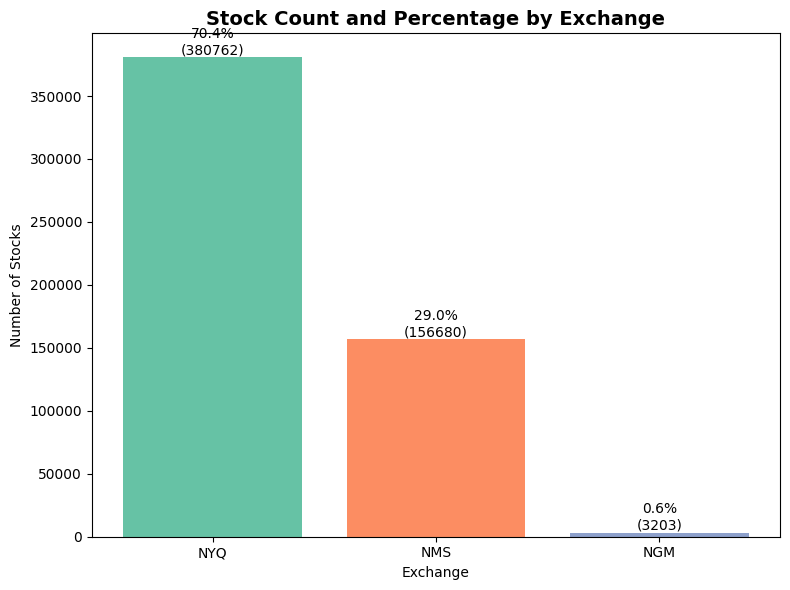

In [11]:
plot_exchange_distribution_bar(df_companies_and_stock)


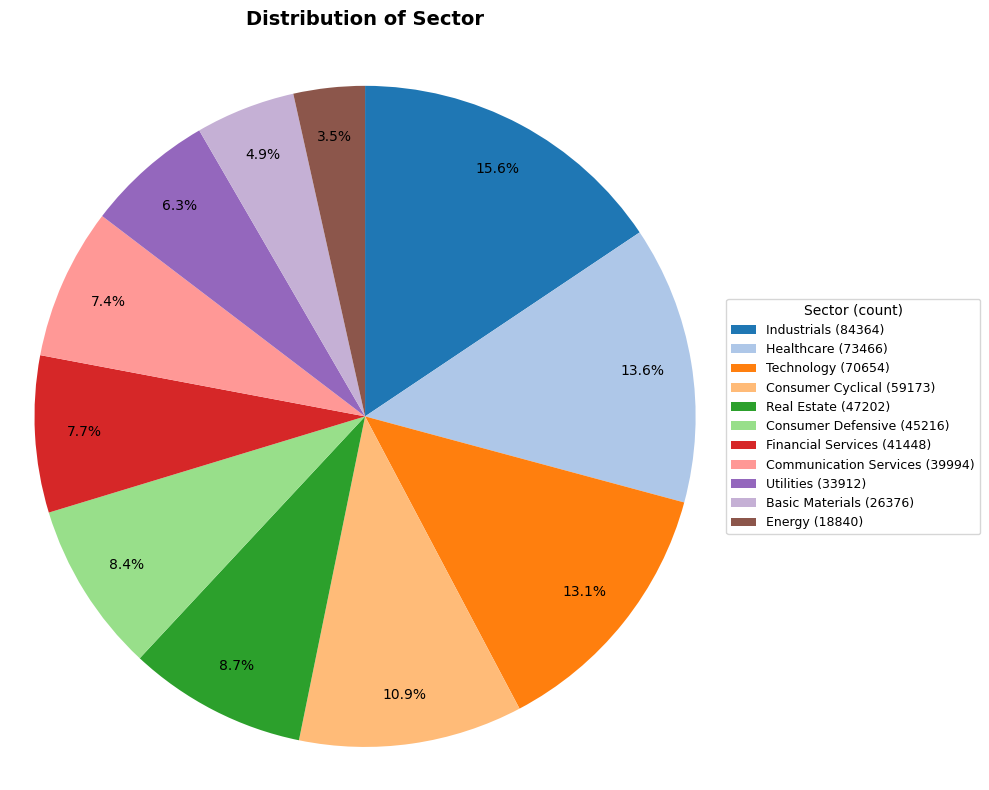

In [12]:
plot_category_pie_chart(df_companies_and_stock, 'Sector')


/tmp/ipython-input-7-2177680750.py:116: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


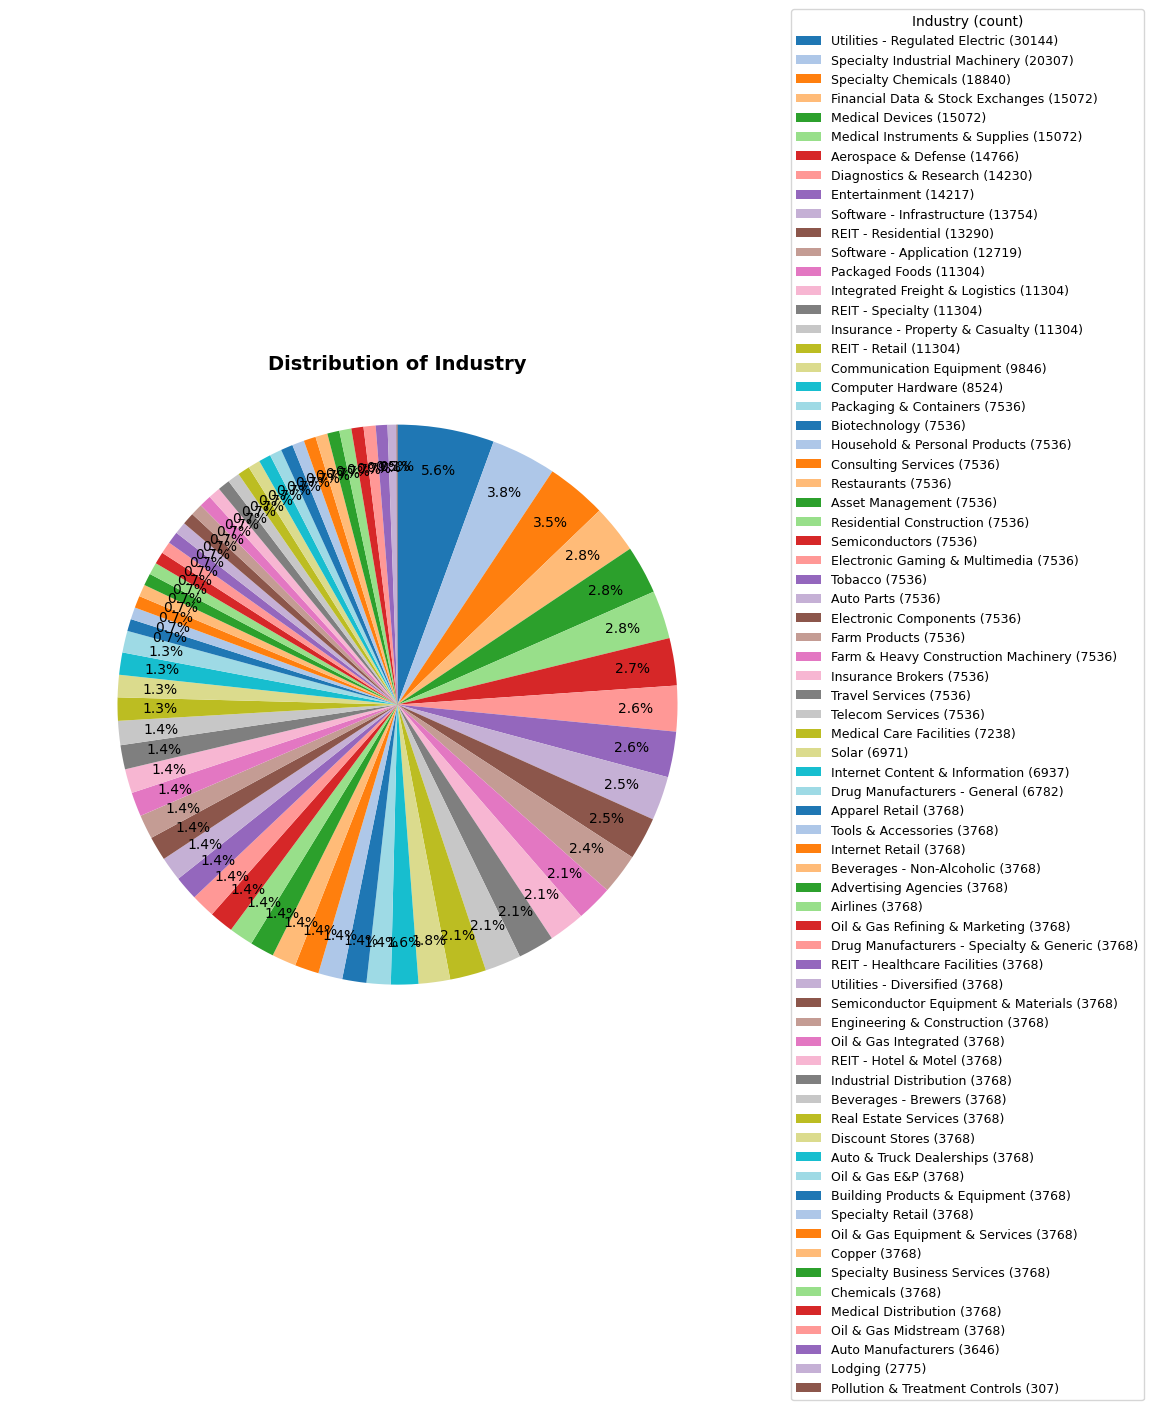

In [13]:
plot_category_pie_chart(df_companies_and_stock, 'Industry') #To look better we can plot just for top 20 or 30


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


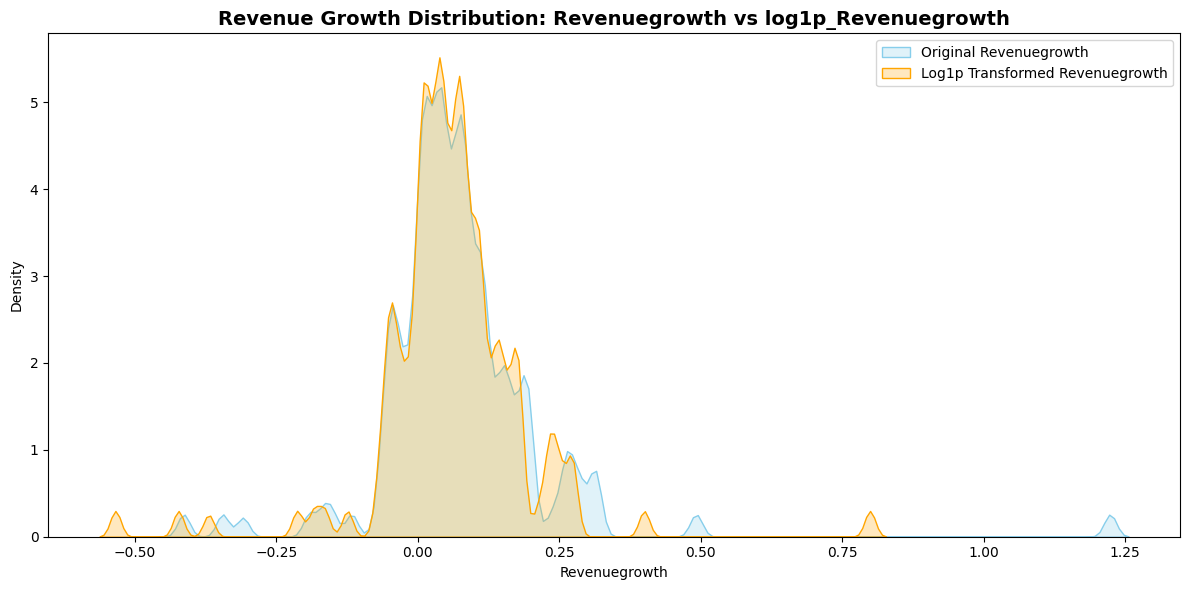

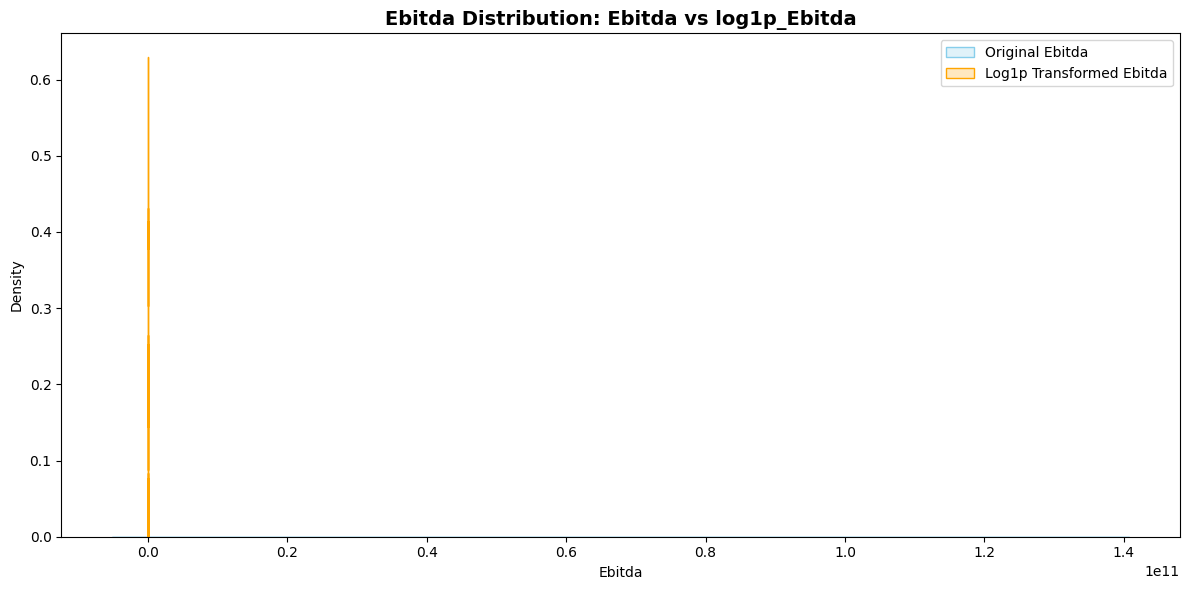

In [14]:


df_companies_and_stock = apply_log1p_transform(df_companies_and_stock, ['Revenuegrowth', 'Ebitda'])
visualize_log1p_transformation(df_companies_and_stock, 'Revenuegrowth', 'log1p_Revenuegrowth', title_prefix="Revenue Growth")
visualize_log1p_transformation(df_companies_and_stock, 'Ebitda', 'log1p_Ebitda', title_prefix="Ebitda")


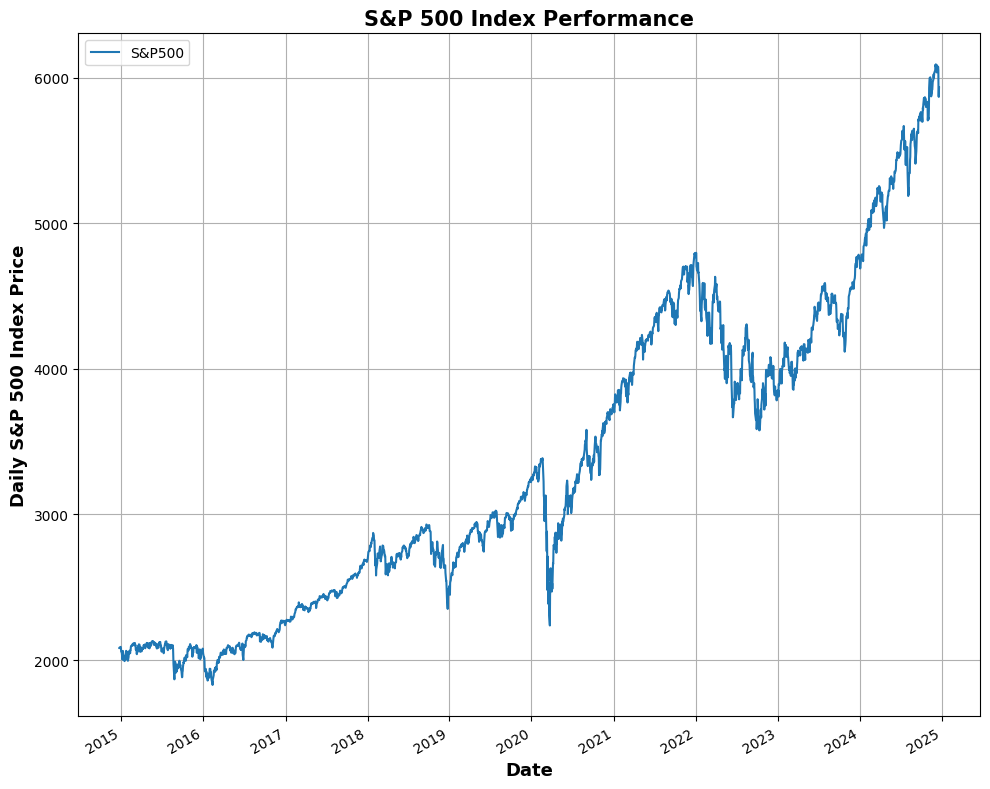

In [15]:
plot_sp500_performance(df_sp500_index)

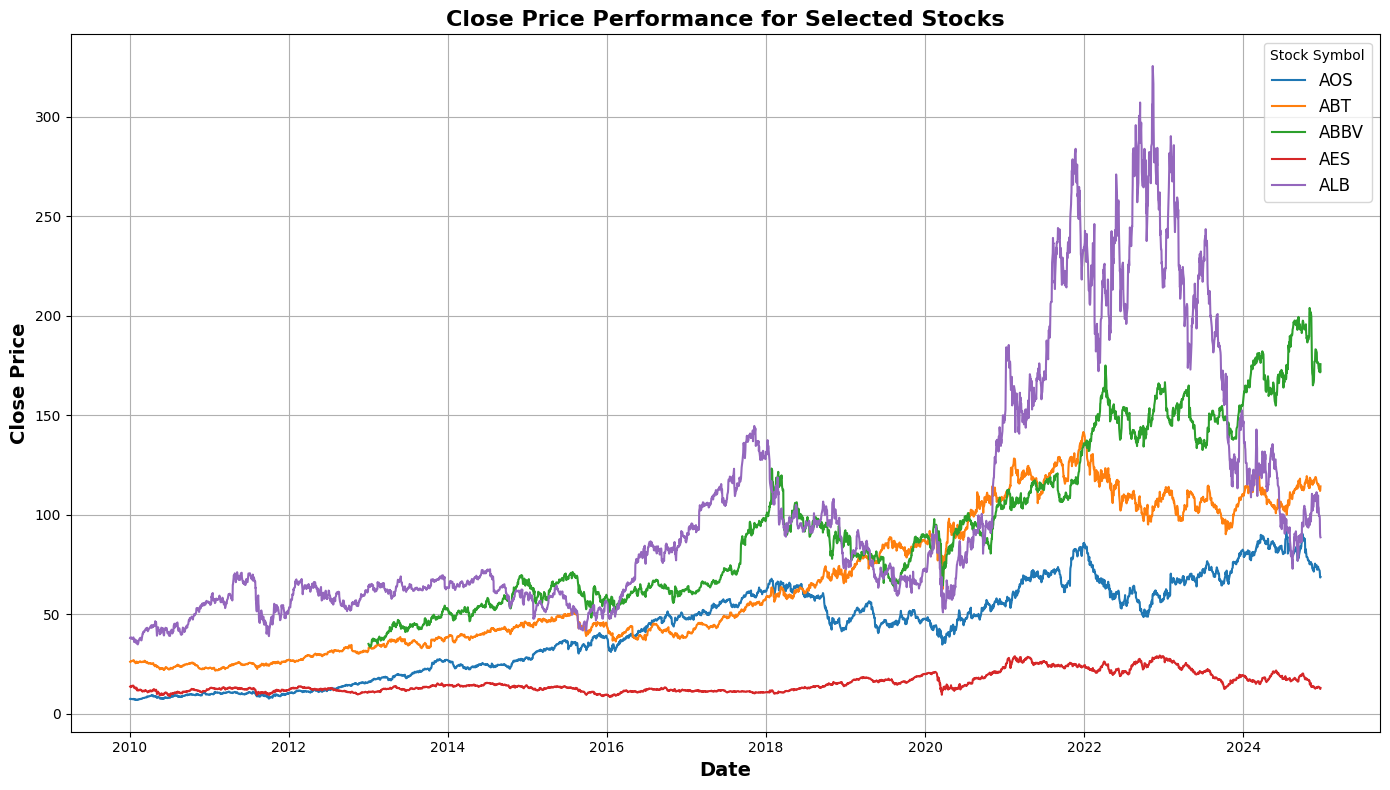

In [16]:
#plot_stock_performance_by_symbol(df_companies_and_stock, ['AAPL', 'MSFT', 'GOOGL'])
plot_stock_performance_by_symbol(df_companies_and_stock, df_companies_and_stock['Symbol'].unique()[:5])


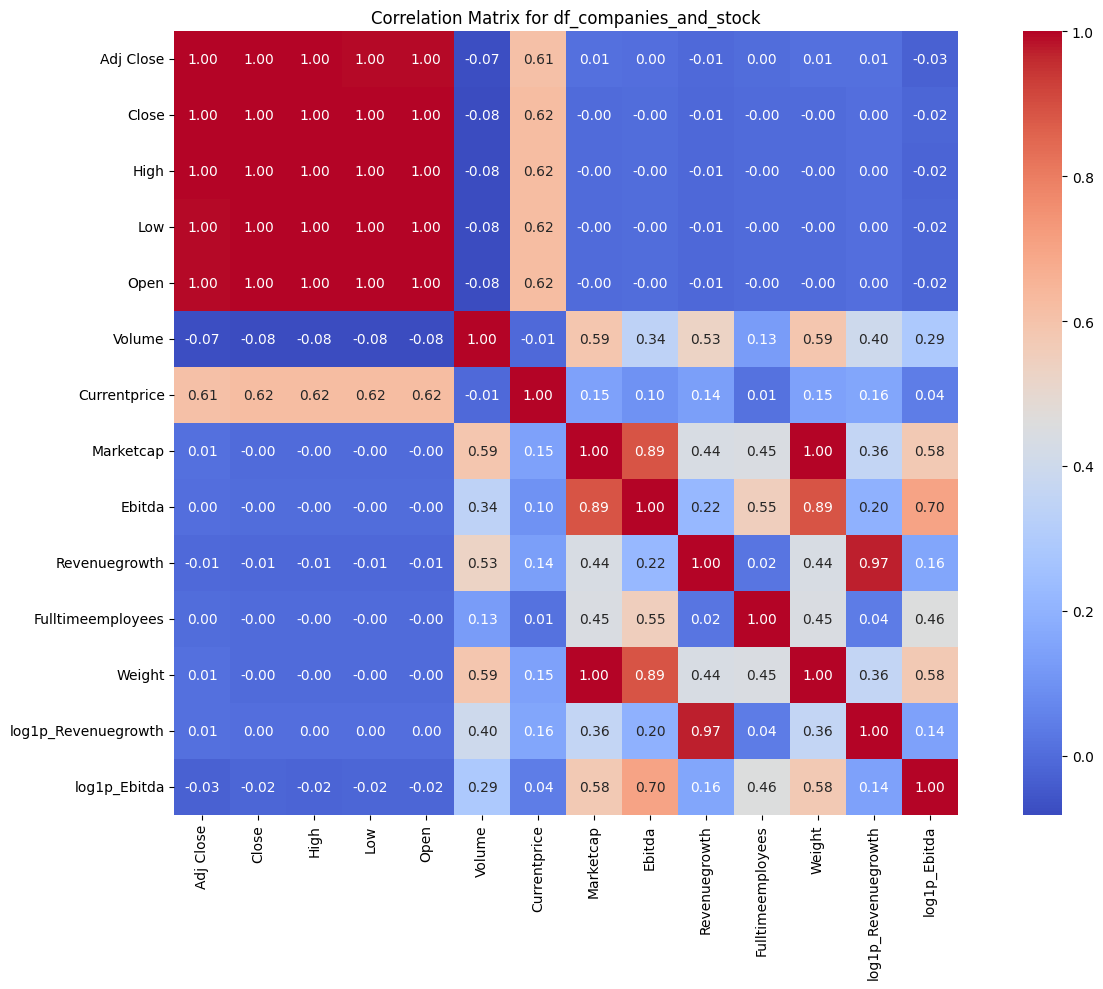

In [17]:
plot_correlation_matrix(df_companies_and_stock, "df_companies_and_stock")


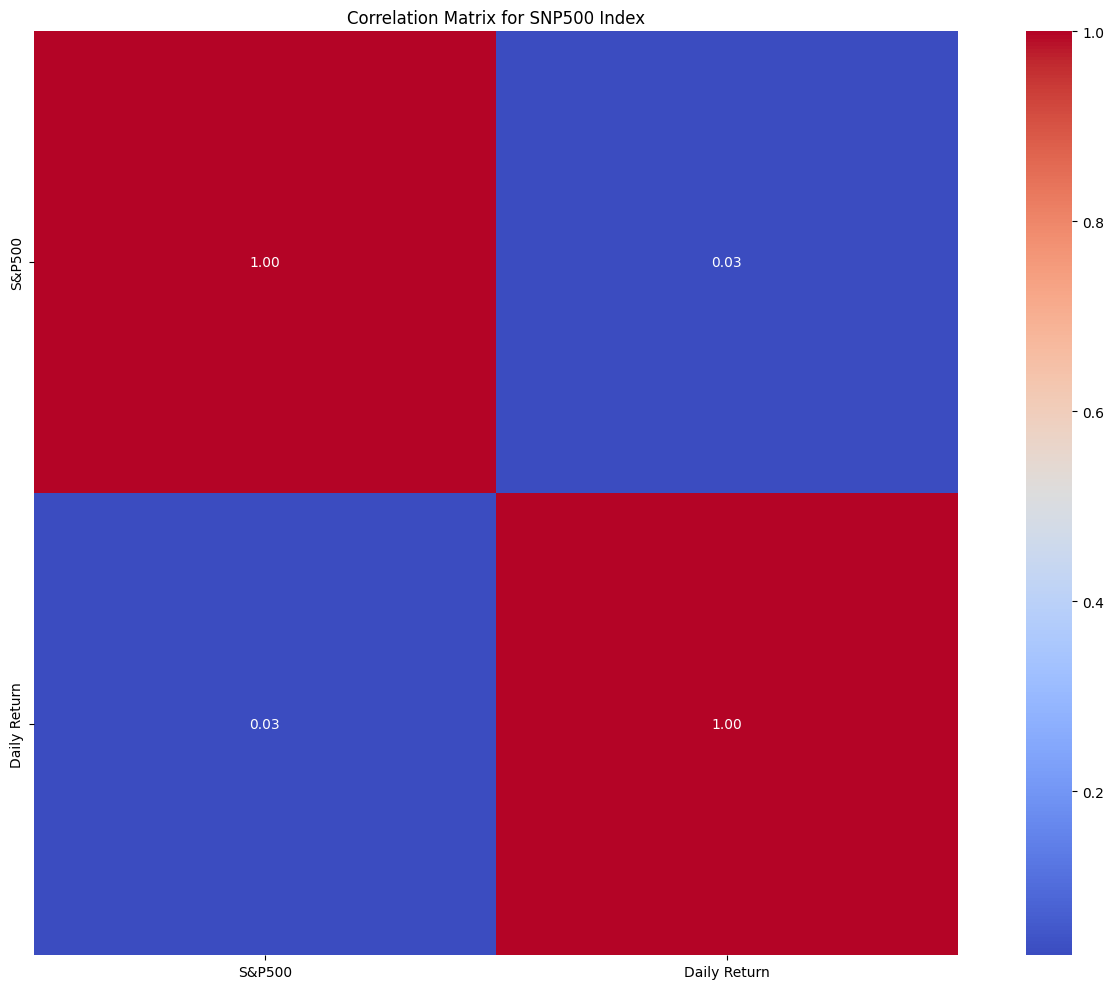

In [18]:
plot_correlation_matrix(df_sp500_index, "SNP500 Index")


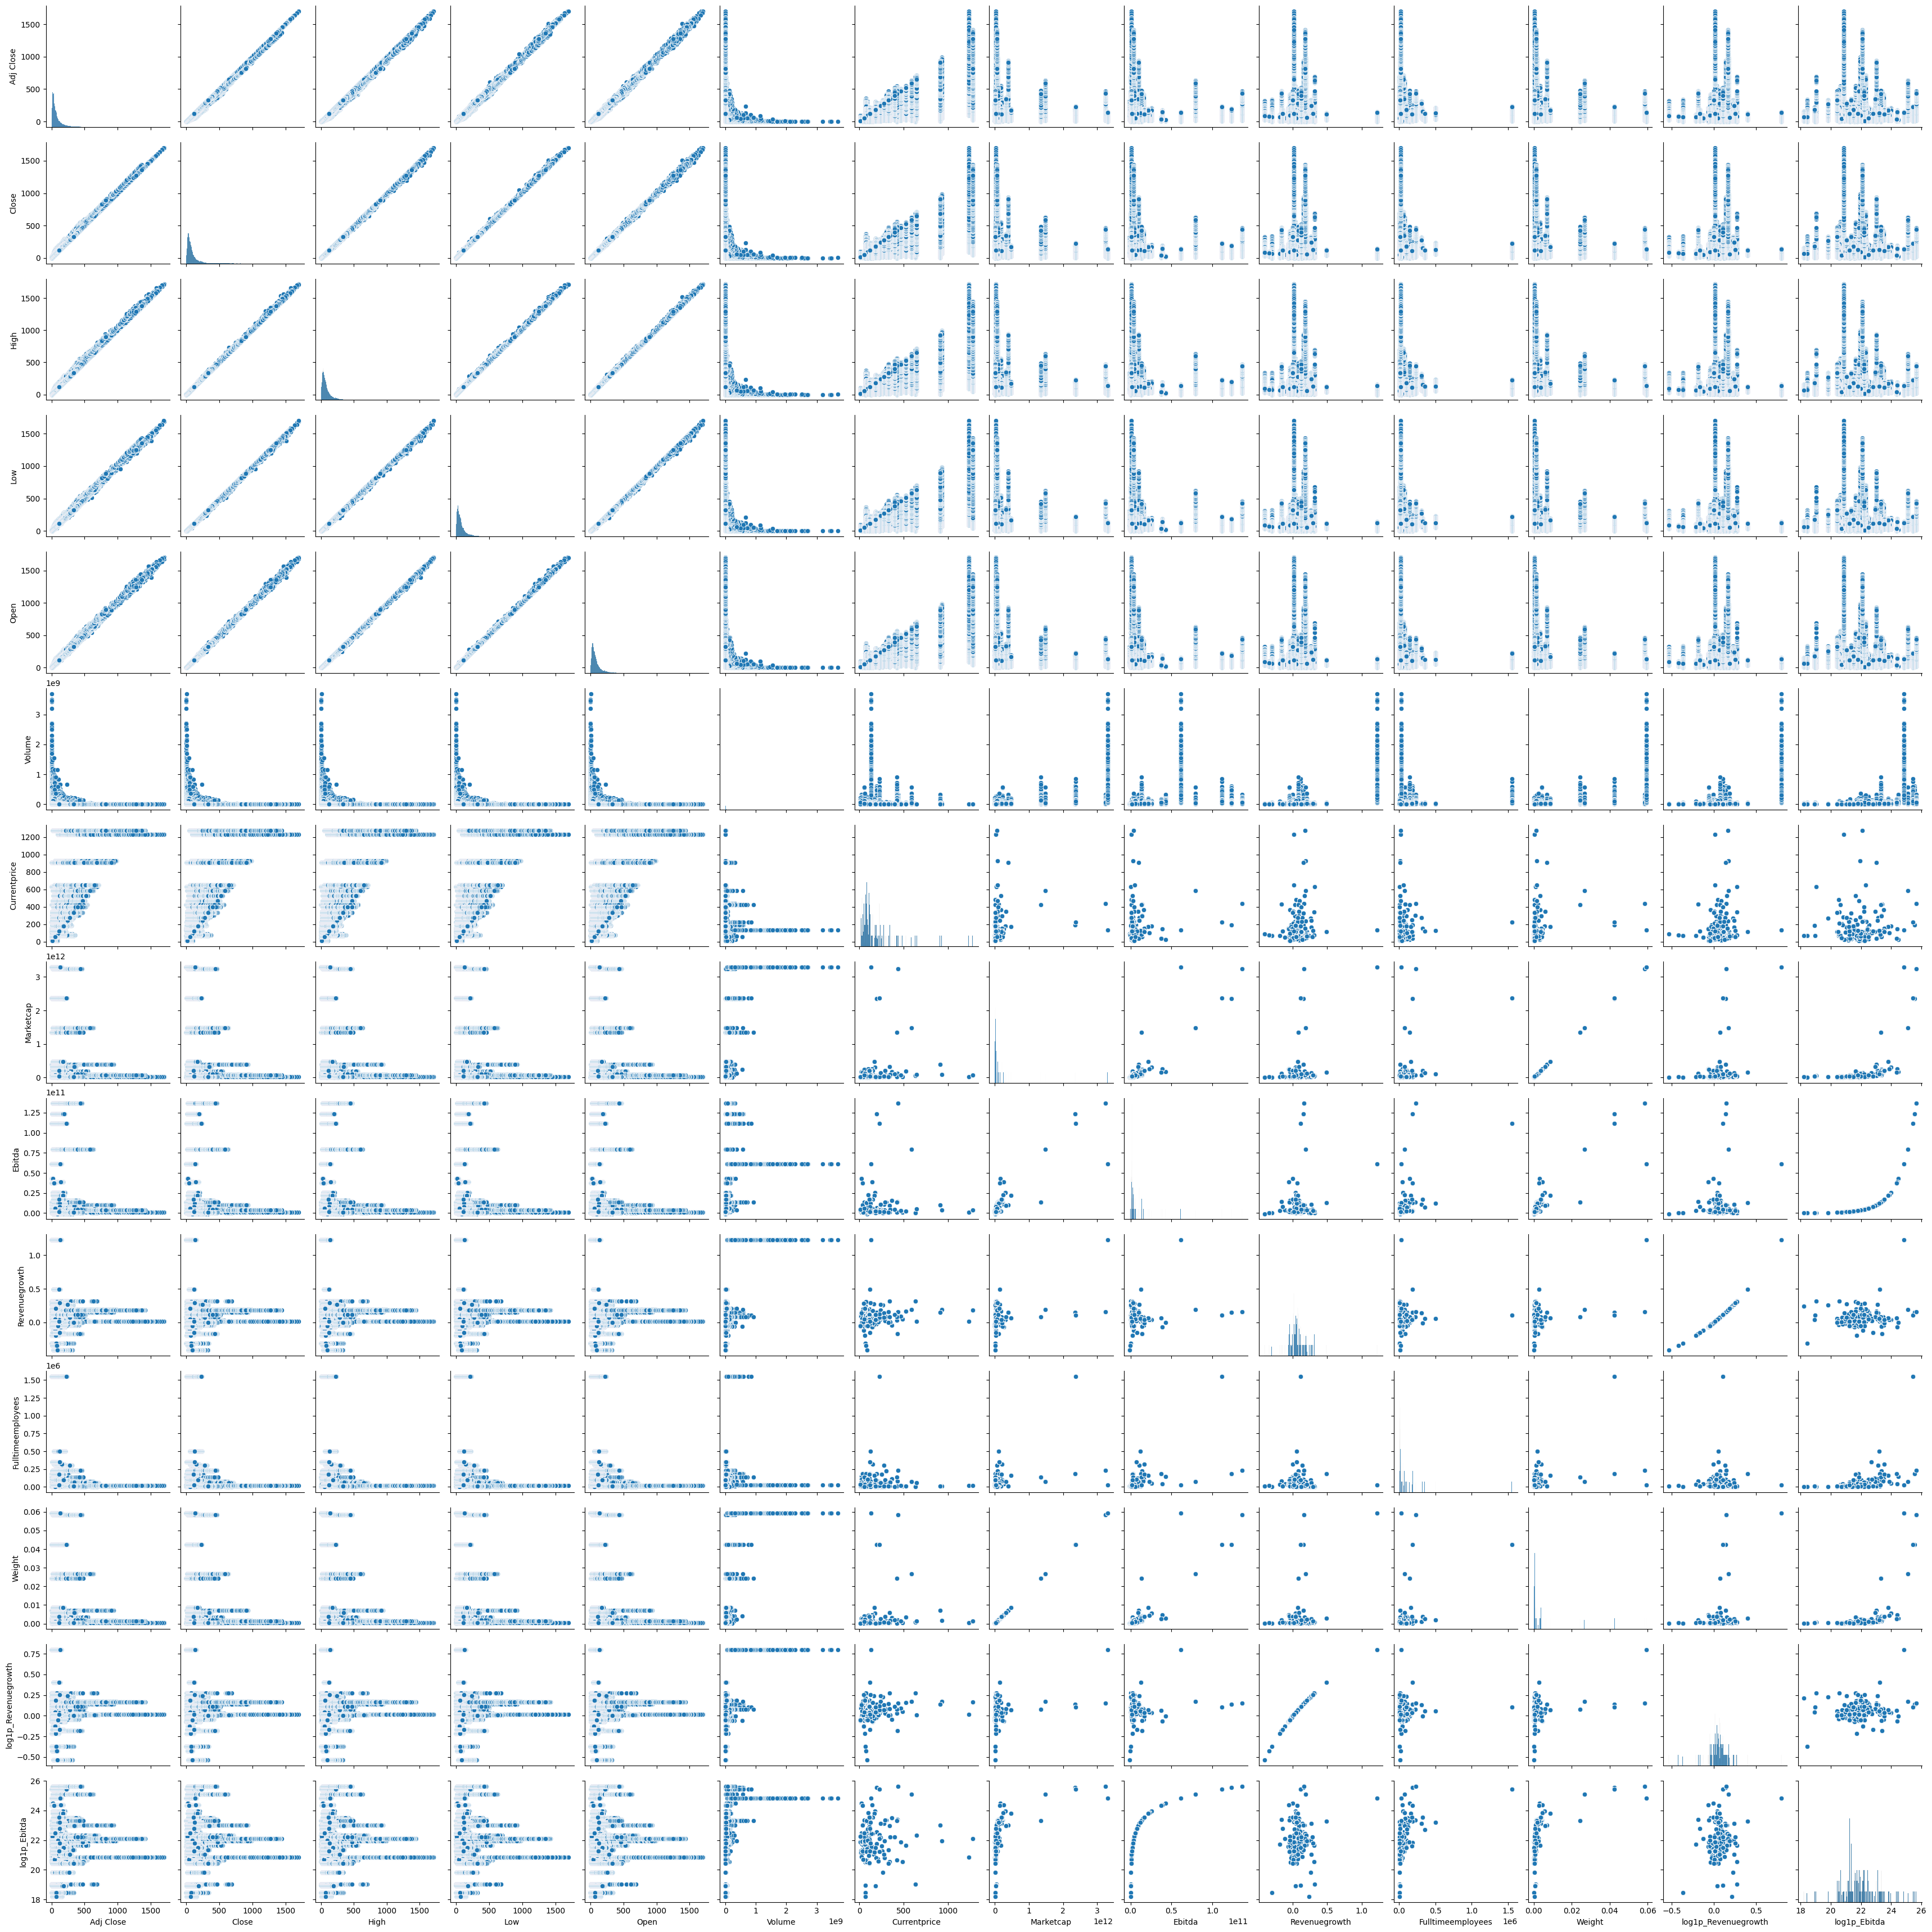

In [19]:
sns.pairplot(df_companies_and_stock)
plt.show()

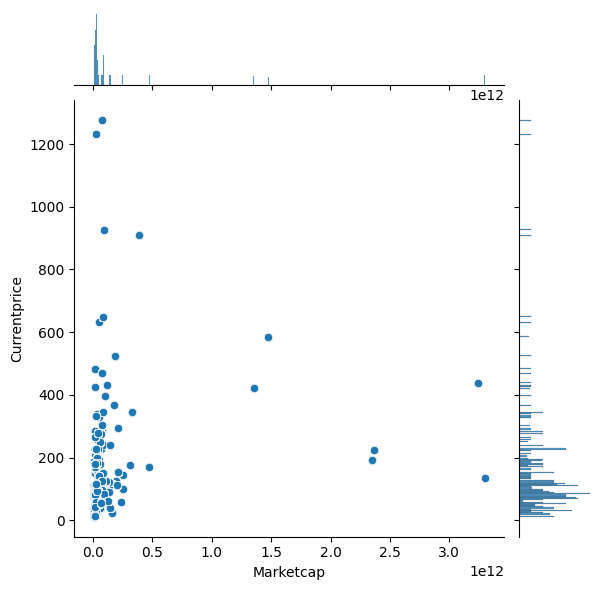

In [20]:
sns.jointplot(data=df_companies_and_stock, x='Marketcap', y='Currentprice', kind='scatter')

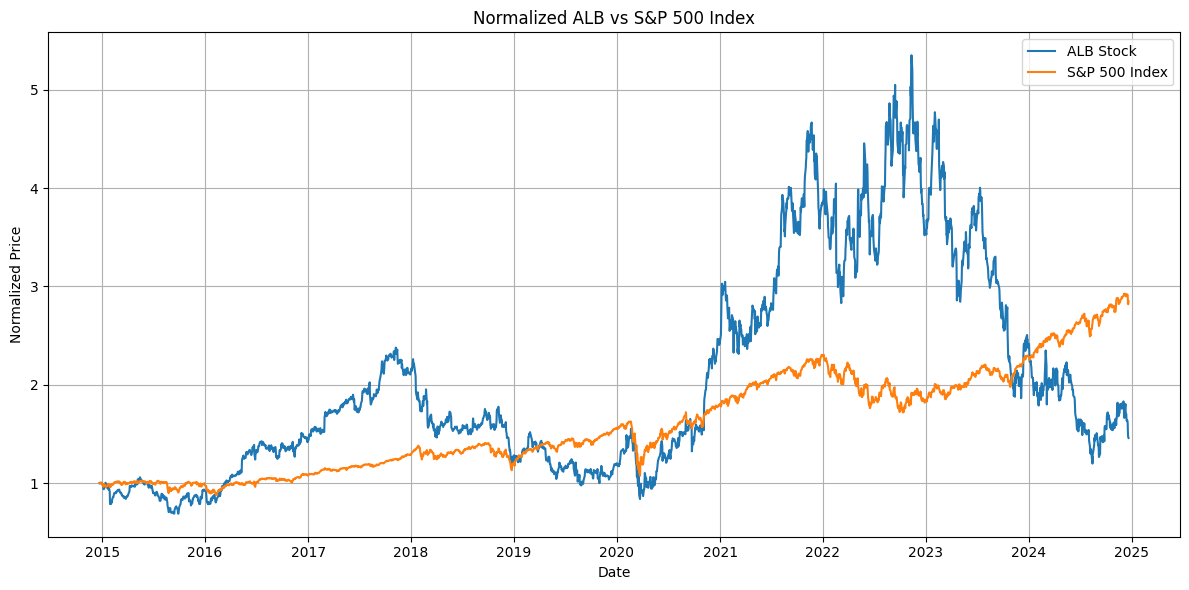

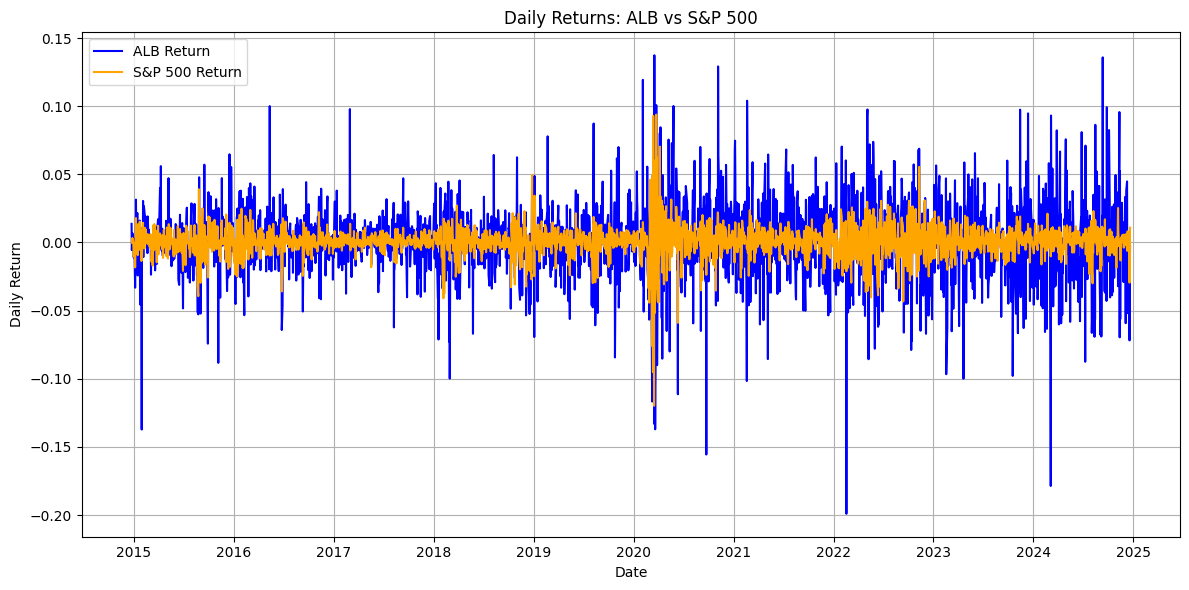

In [21]:
plot_index_vs_stock(df_companies_and_stock, df_sp500_index, 'ALB')
plot_return_comparison(df_companies_and_stock, df_sp500_index, 'ALB')


Observation:

| **Data Type**            | **Characteristics**                                      |
| ------------------------ | ----------------------------------------------------------------- |
| **Stock Price Data**     | Noisy, nonlinear, highly autocorrelated                           |
| **Technical Indicators** | Capture momentum, volatility, mean reversion (nonlinear patterns) |
| **Fundamentals**         | Company financials, slow-changing over time                       |
| **Sector / Industry**    | Categorical groupings affecting behavior                          |


# Quantitative Machine Learning Models

Build a machine learning model that classifies stock for high vs low, out performanced stocks vs losers which are use for allocating capital, managing portfolio risk and generate trading signals as indicated in the Table below:

In [22]:
# Model train and evaluation functions
# Model metrics fucntion
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    auc,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    roc_curve
)

# Model selection and splitting
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    ParameterSampler
)

# Model train and evaluation functions
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        # Changed the variable name from 'auc' to 'roc_auc_value_calculated'
        roc_auc_value_calculated = roc_auc_score(y_test, y_proba)
        auc_score_display = roc_auc_value_calculated
    except AttributeError:
        y_proba = None
        auc_score_display = "N/A"

    print(f"\n{model_name} Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    # Use the new variable name for display
    print("AUC Score:", auc_score_display)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Return the scalar AUC value
    # Make sure to return the calculated value, not the display string
    return y_pred, y_proba, roc_auc_value_calculated if y_proba is not None else None

#Ploting the curve function
def plot_roc_curve(y_test, y_proba, label="Model"):
    # Check if y_proba is available
    if y_proba is None:
        print(f"ROC curve cannot be plotted for {label}: predict_proba not available.")
        return

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # Use the imported auc function from sklearn.metrics
    roc_auc_value = auc(fpr, tpr) # This now correctly calls the imported function

    plt.figure(figsize=(6, 5))
    # Use the calculated scalar AUC value for the label
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_value:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Confusion matrix heatmap function
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_confusion_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

In [36]:
# Model selection and splitting
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    ParameterSampler
)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict labels and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probability for class 1

    # Evaluation metrics
    print(f"{model_name} Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return y_pred, y_proba

| Model             | Summary                                                                              |
| ----------------- | ------------------------------------------------------------------------------------ |
| **Random Forest** | Very stable, interpretable, great for identifying patterns in noisy risk data        |
| **XGBoost**       | More aggressive, better at squeezing out small predictive signals from stock returns |


In [24]:
# First, make sure Date columns are datetime
df_companies_and_stock['Date'] = pd.to_datetime(df_companies_and_stock['Date'])
df_sp500_index['Date'] = pd.to_datetime(df_sp500_index['Date'])

# Merge index data
df = pd.merge(df_companies_and_stock, df_sp500_index[['Date', 'S&P500', 'Daily Return']],
              on='Date', how='inner')

# Sort by Symbol and Date
df.sort_values(["Symbol", "Date"], inplace=True)

df_sp500_index

## Feature Engineering

The following features are used to build a predictive model for the reasons listed in Predictive Contribution.

| Feature         | Type        | What It Captures                                      | Predictive Contribution                                      |
| --------------- | ----------- | ----------------------------------------------------- | ------------------------------------------------------------ |
| `Return`        | Technical   | Daily price change as a percentage                    | Reflects immediate price momentum or reversal                |
| `Volatility`    | Technical   | 20-day rolling standard deviation of returns          | Measures recent risk or instability in price behavior        |
| `Momentum_20`   | Technical   | 20-day percentage price change                        | Captures short- to medium-term trends                        |
| `SMA_20`        | Technical   | 20-day simple moving average                          | Identifies trend direction and price smoothing               |
| `Marketcap`     | Fundamental | Company's market value                                | Helps distinguish between large, mid, and small cap behavior |
| `Revenuegrowth` | Fundamental | Company’s revenue growth rate                         | Indicates business expansion or investor optimism            |
| `Ebitda`        | Fundamental | Earnings before interest, taxes, depreciation, amort. | Proxy for operational profitability                          |
| `Currentprice`  | Price-based | Most recent adjusted close price                      | Used in relative comparisons (e.g., deviation from SMA)      |


In [25]:
# Calculate stock daily return
df['Return'] = df.groupby('Symbol')['Adj Close'].pct_change()

# 20-day rolling volatility (stock)
df['Volatility'] = df.groupby('Symbol')['Return'].rolling(20).std().reset_index(0, drop=True)

# 20-day simple moving average (stock)
df['SMA_20'] = df.groupby('Symbol')['Adj Close'].rolling(20).mean().reset_index(0, drop=True)

# 20-day momentum (price change over 20 days)
df['Momentum_20'] = df.groupby('Symbol')['Adj Close'].pct_change(20)

# Lag features to prevent data leakage
df['Volatility_Lag'] = df.groupby('Symbol')['Volatility'].shift(1)
df['Momentum_20_Lag'] = df.groupby('Symbol')['Momentum_20'].shift(1)
df['Return_Lag'] = df.groupby('Symbol')['Return'].shift(1)

# 20 days moving average
df['SMA_20'] = df.groupby('Symbol')['Adj Close'].transform(lambda x: x.rolling(window=20).mean())

# Fill NA for fundamentals
fundamental_features = ['Marketcap', 'Revenuegrowth', 'Ebitda', 'SMA_20', ]
df[fundamental_features] = df[fundamental_features].fillna(0)

# Drop rows with missing values
df.dropna(inplace=True)

## Create Target

Target: Binary indicator where
1 = the stock's adjusted closing price 20 days in the future is higher than today's price,
0 = otherwise.

In [26]:
 # A. Volatility Classification Target (High vs Low risk)
vol_thresh = df.groupby('Date')['Volatility_Lag'].transform(lambda x: x.quantile(0.7))
df['RiskClass'] = (df['Volatility_Lag'] > vol_thresh).astype(int)

# B. Outperformance Classification Target (compare stock return to index daily return)
df['Outperformer'] = (df['Return'] > df['Daily Return']).astype(int)

In [27]:
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point]
test = df[df['DateInt'] > split_point]
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point]
test = df[df['DateInt'] > split_point]

# Features to use
feature_cols = ["Return", "Volatility", "Momentum_20", "SMA_20", "Marketcap", "Revenuegrowth", "Ebitda", "Currentprice"]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])

# Targets
y_train_risk = train['RiskClass']
y_test_risk = test['RiskClass']

y_train_perf = train['Outperformer']
y_test_perf = test['Outperformer']
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])

# Targets
y_train_risk = train['RiskClass']
y_test_risk = test['RiskClass']

y_train_perf = train['Outperformer']
y_test_perf = test['Outperformer']

## Prediction with **XGBoost** Model

In [31]:
print(X_train.shape, y_train_perf.shape)
print(X_test.shape, y_test_perf.shape)


(289698, 8) (289698,)
(72316, 8) (72316,)


In [32]:
# Initialize the XGBoost model for outperformance
perf_model = XGBClassifier(n_estimators=100, random_state=42)

In [37]:
perf_pred, perf_proba = train_and_evaluate(
    perf_model,
    X_train,
    y_train_perf,
    X_test,
    y_test_perf,
    model_name="XGBoost model"
)

XGBoost model Performance
Accuracy: 0.8069721776646939
AUC Score: 0.8835411065197953
Confusion Matrix:
 [[29335  7472]
 [ 6487 29022]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81     36807
           1       0.80      0.82      0.81     35509

    accuracy                           0.81     72316
   macro avg       0.81      0.81      0.81     72316
weighted avg       0.81      0.81      0.81     72316



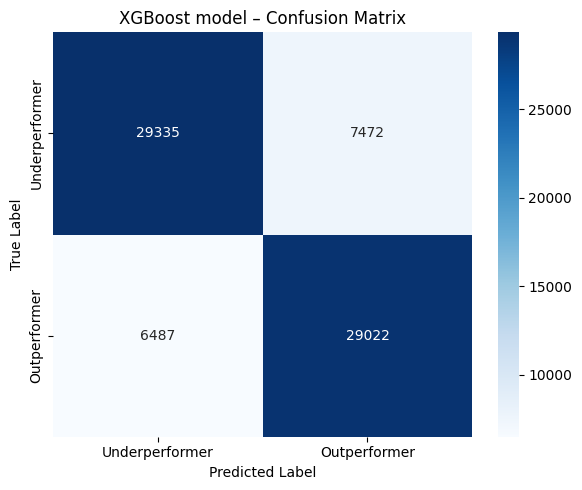

Accuracy: 0.81
Precision: 0.80
Recall: 0.82
F1 Score: 0.81


In [38]:
# Compute confusion matrix
plot_confusion_matrix(
    y_test_perf,
    perf_pred,
    labels=["Underperformer", "Outperformer"],
    title="XGBoost model – Confusion Matrix"
)

print_confusion_metrics(y_test_perf, perf_pred)

The XGBoost model achieved an accuracy of 0.81, with a precision of 0.80, recall of 0.82, and an F1 score of 0.81. These results indicate a strong balance between correctly identifying outperforming stocks and minimizing false predictions. The high F1 score reflects the model's effectiveness in handling both types of classification errors, making it a reliable tool for predicting stock outperformance in contexts where both false positives and false negatives carry significant impact.

The model identifies outperformers (Class 1) with 62% recall and 50% precision, but underperforms on Class 0 with lower recall (39%). The Outperformance model is slightly better at finding outperformers (class 1) than underperformers.
It captured 62% of real outperformers (recall). However, when the model predicts a stock will outperform, it's only correct about 50% of the time.
The overall accuracy is 50%, which is roughly random guessing.


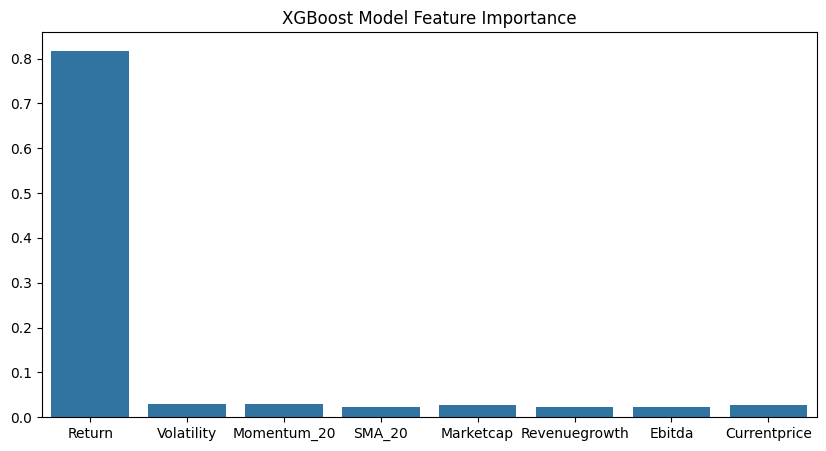

In [39]:
plt.figure(figsize=(10,5))
sns.barplot(x=feature_cols, y=perf_model.feature_importances_)
plt.title("XGBoost Model Feature Importance")
plt.show()

Volatility_Lag is by far the most important feature (contributes (~58%))and Momenton_20_lag contributes 23%. Fundamentals (Market cap, Revenue growth, Ebitda, Fulltime employees) have very little impact
Volatility is highly autocorrelated (today’s volatility predicts tomorrow’s volatility — which is very consistent with market microstructure).
Momentum plays a smaller but still meaningful role.
Fundamentals barely contribute to short-term volatility prediction.

Conclusion:
The risk model is almost purely driven by technical features (makes sense for short-term volatility).
Other data such as realized volatility for intra day, sector variables (tech vs utilities vs financials) and VIX index (market-wide volatility gauge) maybe added for a fuller and biger picture.

Much more balanced feature contributions.
All 6 features (technical + fundamentals) contribute quite equally.
Fundamentals like Marketcap, Revenue Growth, EBITDA are meaningful for predicting stock outperformance.

Interpretation:

Outperformance is multi-factor: both technical signals and company fundamentals influence whether a stock beats the index with growth, profitability, and size factors are all drivers of stock returns.

Conclusion:
The outperformer model is working as intended: combining technical + fundamental data gives better explanatory power than either alone.

## Change Prediction to 20 days

In [40]:
df['10d_return'] = df.groupby('Symbol')['Adj Close'].pct_change(10)
df['Outperformer'] = (df['10d_return'] > df['10d_return'].median()).astype(int)

In [41]:
# Calculate 20-day stock return
df['Return_20d'] = df.groupby('Symbol')['Adj Close'].pct_change(20)

# Calculate 20-day index return
df['Index_Return_20d'] = df['S&P500'].pct_change(20)

# Create the outperformer target:
# If stock return > index return over same 20-day window
df['Outperformer_20d'] = (df['Return_20d'] > df['Index_Return_20d']).astype(int)

In [42]:
# Time-based split
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point]
test = df[df['DateInt'] > split_point]

# Features
feature_cols

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])

# Targets: 20-day Outperformance
y_train = train['Outperformer_20d']
y_test = test['Outperformer_20d']

## TRAIN XGBoost MODEL ON 20 DAYS MOVING AVERAGE

In [43]:
# Train and evaluate the XGBoost model
model = XGBClassifier(n_estimators=100, random_state=42)

y_pred, y_pred_proba = train_and_evaluate(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="XGBoost"
)

# Confusion matrix
print_confusion_metrics(y_test, y_pred)

XGBoost Performance
Accuracy: 0.831378947950661
AUC Score: 0.9226976879144753
Confusion Matrix:
 [[30725  7801]
 [ 4393 29397]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     38526
           1       0.79      0.87      0.83     33790

    accuracy                           0.83     72316
   macro avg       0.83      0.83      0.83     72316
weighted avg       0.84      0.83      0.83     72316

Accuracy: 0.83
Precision: 0.79
Recall: 0.87
F1 Score: 0.83


In [46]:
# Save the trained XGBoost model
joblib.dump(model, 'xgboost_model.pkl')
print("XGBoost model saved as xgboost_model.pkl")

XGBoost model saved as xgboost_model.pkl


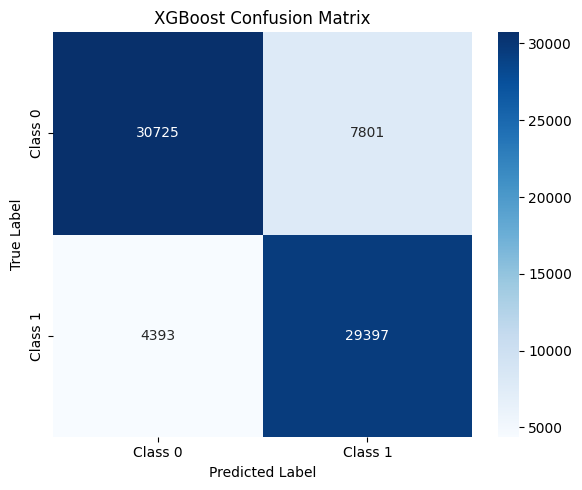

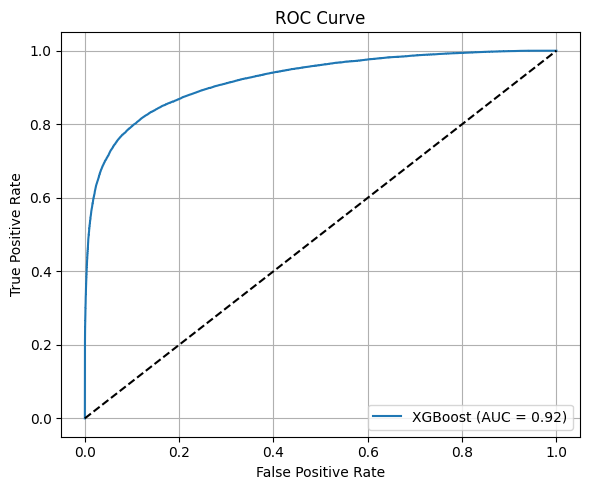

In [47]:
plot_confusion_matrix(y_test, y_pred, labels=["Class 0", "Class 1"], title="XGBoost Confusion Matrix")
plot_roc_curve(y_test, y_pred_proba, label="XGBoost")

For the Outperforamnce Model, the ROC curve bows sharply toward the top-left corner, indicating high sensitivity and specificity. With an AUC of 0.92, the model demonstrates excellent discriminative ability—meaning it has a 92% chance of correctly ranking a randomly chosen positive instance higher than a negative one. Compare to the Risk Model, the Outperformace Model has similar ROC (at 92 for Out Performance Model vs 0.91 for Risk Model). As a next step, hyperparameter optimization techniques such as grid search or randomized search can be applied to determine whether fine-tuning the model parameters leads to even higher AUC scores and improved overall performance. This is only applied to Outperformance Model to test the theory since it performed a slight higher.

# Hyperparameter tuning

This step is for tuning the XGBoost model to find the best combination of hyperparameters using grid search, optimizing for accuracy, and using logloss as an internal evaluation metric.

| **Indicator**                     | **Reason**                        |
| --------------------------------- | --------------------------------- |
| **RSI (Relative Strength Index)** | Overbought/oversold strength      |
| **MACD**                          | Trend-following                   |
| **ATR (Average True Range)**      | Smarter volatility                |
| **Bollinger Bands**               | Price deviation vs moving average |
| **OBV (On Balance Volume)**       | Volume + price momentum           |




In [48]:
df = pd.get_dummies(df, columns=['Sector', 'Industry'])

In [51]:
# Apply indicators
df['RSI'] = ta.rsi(df['Close'], length=14)
df['MACD'] = ta.macd(df['Close'])['MACD_12_26_9']
df['ATR'] = ta.atr(high=df['High'], low=df['Low'], close=df['Close'], length=14)
bb = ta.bbands(df['Close'], length=20)
df['BB_width'] = bb['BBU_20_2.0'] - bb['BBL_20_2.0']
df['OBV'] = ta.obv(df['Close'], df['Volume'])

In [52]:
# Create mean and median:
df['Rolling_Return_5'] = df.groupby('Symbol')['Return'].rolling(5).mean().reset_index(0, drop=True)
df['Rolling_Vol_5'] = df.groupby('Symbol')['Return'].rolling(5).std().reset_index(0, drop=True)

In [65]:
feature_cols = ['Return', 'Volatility', 'Momentum_20', 'SMA_20',
                'Marketcap', 'Revenuegrowth', 'Ebitda', 'Currentprice']
X = df[feature_cols]
# Changed 'Target' to 'Outperformer_20d'
y = df['Outperformer_20d']

In [66]:
print(df.columns.tolist())

['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Exchange', 'Shortname', 'Longname', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight', 'log1p_Revenuegrowth', 'log1p_Ebitda', 'S&P500', 'Daily Return', 'Return', 'Volatility', 'SMA_20', 'Momentum_20', 'Volatility_Lag', 'Momentum_20_Lag', 'Return_Lag', 'RiskClass', 'Outperformer', 'DateInt', '10d_return', 'Return_20d', 'Index_Return_20d', 'Outperformer_20d', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities', 'Industry_Advertising Agencies', 'Industry_Aerospace & Defense', 'Industry_Airlines', 'Industry_Apparel Retail', 'Industry_Asset Management', 'Industry_Auto & Truck Dealerships', 'Industry_Auto Manufacturers', 

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [68]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [69]:
# Initialize base XGB model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [70]:
# Train data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [71]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Best CV Score: 0.8283783213039383


In [72]:
# Find the best model for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     45035
           1       0.85      0.79      0.82     45469

    accuracy                           0.83     90504
   macro avg       0.83      0.83      0.82     90504
weighted avg       0.83      0.83      0.82     90504

Test Accuracy: 0.8250906037302219


In [73]:
# Predict
y_pred = best_model.predict(X_test)

In [74]:
# Save model
joblib.dump(best_model, 'best_model_XGB.pkl')
print("Best model saved as best_model_XGB.pkl")

Best model saved as best_model_XGB.pkl


              precision    recall  f1-score   support

           0       0.80      0.86      0.83     45035
           1       0.85      0.79      0.82     45469

    accuracy                           0.83     90504
   macro avg       0.83      0.83      0.82     90504
weighted avg       0.83      0.83      0.82     90504

Test Accuracy: 0.8250906037302219


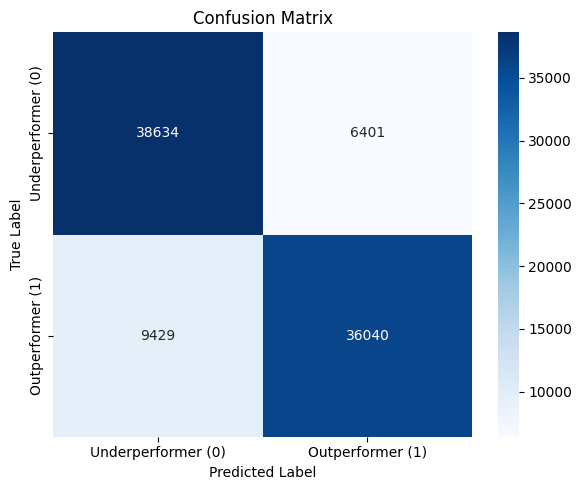

In [75]:
# Classification report
print(classification_report(y_test, y_pred))

# Accuracy score
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
plot_confusion_matrix(
    y_test,
    y_pred,
    labels=["Underperformer (0)", "Outperformer (1)"],
    title="Confusion Matrix"
)

Test ROC AUC: 0.7552


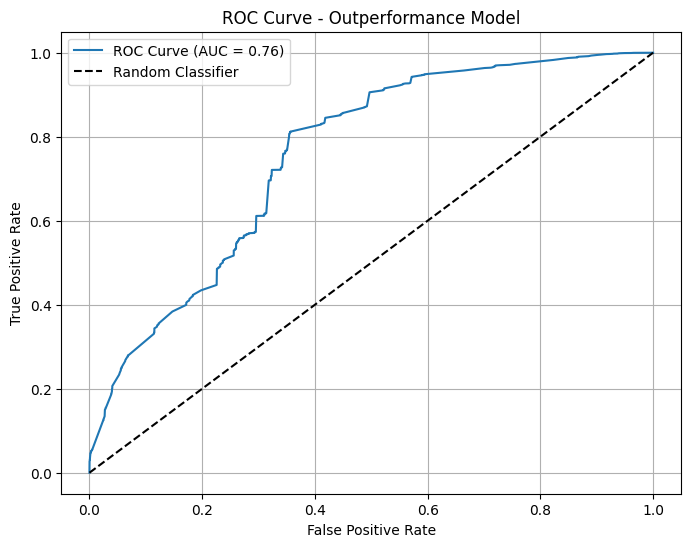

In [76]:
# Get predicted probabilities for the positive class
# Probability of class 1 (Outperformer)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {auc:.4f}")

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Outperformance Model')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# Save all models in Google Drive
joblib.dump(best_model, '/content/drive/MyDrive/best_model_XGB.pkl')

['/content/drive/MyDrive/best_model_XGB.pkl']

In [78]:
import os
print(os.getcwd())

/content


The XGBoost model was trained on a 20-day prediction horizon using a combination of technical and fundamental indicators, including rolling return features. Hyperparameter tuning via grid search explored variations in tree depth, learning rate, and sampling strategies. The final model achieved a solid test accuracy of 82.5%, with well-balanced precision and recall across both outperformers and underperformers. While the performance gain over default parameters was modest, the model achieved a strong ROC-AUC score of 0.76, indicating reliable ranking capability. This suggests the model is particularly useful for prioritizing high-potential stocks for further analysis, even when classification thresholds remain relatively stable.

# Conclusion

The XGBoost-based Outperformance Model demonstrates strong predictive performance in classifying stocks into outperformers and underperformers. The model achieved a test accuracy of 82.5%, reflecting reliable generalization to unseen data. The ROC AUC score of 0.76 further confirms the model’s ability to discriminate between the two classes beyond random chance.

Precision and recall are well-balanced across both classes. The model was slightly more effective at identifying underperformers, with higher recall, while maintaining strong precision in predicting outperformers. This indicates that the model not only captures patterns associated with high-performing stocks but also avoids excessive false positives, which is critical in financial applications.

The confusion matrix reinforces this balanced performance, showing the model correctly predicted over 38,000 underperformers and 36,000 outperformers, with a relatively low number of misclassifications. These results suggest the model is a valuable tool for screening stocks and identifying those likely to outperform over a defined future period.

Overall, the model offers meaningful insights and robust performance. Future enhancements could include incorporating more advanced technical indicators, refining features through dimensionality reduction or feature selection, and exploring time-aware validation methods to further align with real-world trading scenarios.

# References

OpenAI. (2023, June 19). ChatGPT. https://chat.openai.com/